In [1]:
from optimize import simulation_LOOCV
import numpy as np
import pandas as pd

读取数据集，按照tau分类

In [2]:
# Load the data
path = 'data/real_2018_6_7_AMD_data.csv'
data = pd.read_csv(path)
data.head()

,date,r,exdate,strick_price(X),option_price(C_bid),option_price(C_offer),close,tau(T/365)
0,2018-07-20,2.069,2018-08-24,10.0,6.45,6.60,16.5,0.09589
1,2018-07-20,2.069,2018-08-24,10.5,5.95,6.10,16.5,0.09589
2,2018-07-20,2.069,2018-08-24,11.0,5.45,5.70,16.5,0.09589
3,2018-07-20,2.069,2018-08-24,11.5,4.95,5.20,16.5,0.09589
4,2018-07-20,2.069,2018-08-24,12.0,4.55,4.65,16.5,0.09589


In [3]:
# 提取tau(T/365)的不重复的值
tau = np.unique(data['tau(T/365)'])
tau = np.sort(tau)
print(tau)

[0.08493151 0.09589041]


In [4]:
# 如果tau(T/365)=tau[0], 设置为训练集
# 如果tau(T/365)=tau[1], 设置为测试集
train = data[data['tau(T/365)'] == tau[0]]
test = data[data['tau(T/365)'] == tau[1]]
# 删除date和exdate
train = train.drop(columns=['date', 'exdate'])
test = test.drop(columns=['date', 'exdate'])
train.head(), test.head()

(          r  strick_price(X)  option_price(C_bid)  option_price(C_offer)  \
 24  2.08788             10.0                 6.65                   6.75   
 25  2.08788             10.5                 6.15                   6.25   
 26  2.08788             11.0                 5.70                   5.75   
 27  2.08788             11.5                 5.20                   5.30   
 28  2.08788             12.0                 4.70                   4.80   
 
     close  tau(T/365)  
 24  16.69    0.084932  
 25  16.69    0.084932  
 26  16.69    0.084932  
 27  16.69    0.084932  
 28  16.69    0.084932  ,
        r  strick_price(X)  option_price(C_bid)  option_price(C_offer)  close  \
 0  2.069             10.0                 6.45                   6.60   16.5   
 1  2.069             10.5                 5.95                   6.10   16.5   
 2  2.069             11.0                 5.45                   5.70   16.5   
 3  2.069             11.5                 4.95              

In [5]:
# 统计训练集中strick_price(X)作为X
X = train['strick_price(X)']
X = np.array(X)
# 统计训练集中option_price(C_bid)作为C_obs
C_obs = train['option_price(C_bid)']
C_obs = np.array(C_obs)
n = len(C_obs)
# 统计r作为r
r= 2.08788 / 100
tau = 0.084932
X, C_obs, n

(array([10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
        15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5,
        21. , 22. , 23. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. ,  9.5]),
 array([ 6.65,  6.15,  5.7 ,  5.2 ,  4.7 ,  4.2 ,  3.75,  3.25,  2.85,
         2.42,  2.02,  1.66,  1.34,  1.06,  0.83,  0.64,  0.49,  0.37,
         0.28,  0.21,  0.16,  0.12,  0.09,  0.05,  0.03, 13.65, 12.65,
        11.65, 10.65,  9.65,  8.65,  7.65,  7.15]),
 33)

In [6]:
from modules.BS_MixG_model import C_MixG
import matplotlib.pyplot as plt

Loss after Opt :  0.04409483102968104


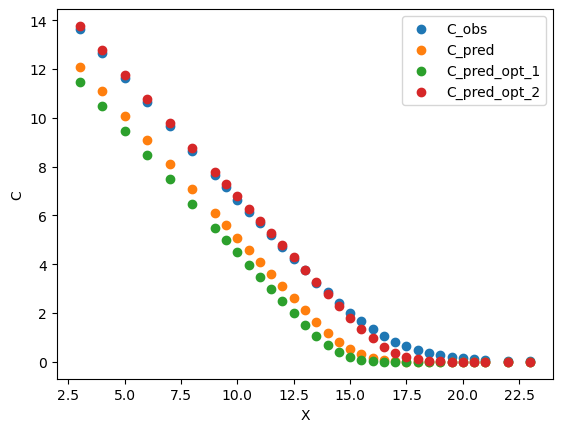

In [8]:
mu_init_value = 2.67
C_pred, C_pred_opt_1, C_pred_opt_2, loss_opt, mu_opt, pi_opt = simulation_LOOCV(0.071, C_obs, n, X, r, tau, 0, mu_init_value)

plt.scatter(X, C_obs, label='C_obs')
plt.scatter(X, C_pred, label='C_pred')
plt.scatter(X, C_pred_opt_1, label='C_pred_opt_1')
plt.scatter(X, C_pred_opt_2, label='C_pred_opt_2')
plt.xlabel('X')
plt.ylabel('C')
plt.legend()
plt.show()

In [13]:
# 用这个模型预测测试集
X_test = test['strick_price(X)']
X_test = np.array(X_test)
C_obs_test = test['option_price(C_bid)']
C_obs_test = np.array(C_obs_test)
n_test = len(C_obs_test)
tau_test = 0.09589041
r = 2.069 / 100
C_pred = C_MixG(X, r, tau, 0.071, mu_opt, pi_opt)
# 计算loss
loss = np.sum((C_obs - C_pred) ** 2) / n
loss

0.04410610543169822

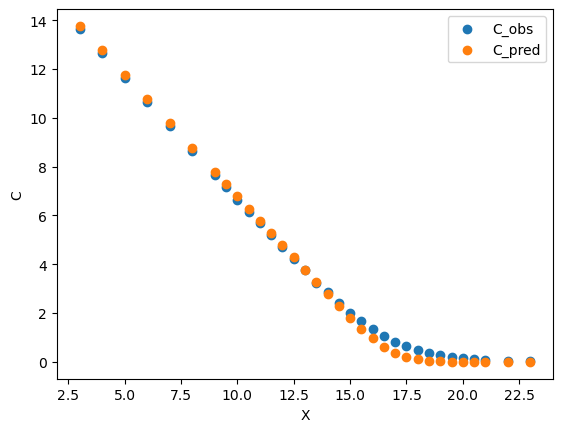

In [14]:

plt.scatter(X, C_obs, label='C_obs')
plt.scatter(X, C_pred, label='C_pred')
plt.xlabel('X')
plt.ylabel('C')
plt.legend()
plt.show()

In [15]:
import torch
from modules.BS_MixG_model import C_MixG_Torch
from modules.BS_Theoretical_Model import BS_Theoretical_Value, add_noise_to_option_values
from utils import loss_torch, constraint_loss
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
class Args:
    def __init__(self, n, r, tau, d):
        self.n = n  # Example: 25
        self.r = r  # Example: 0.045
        self.tau = tau  # Example: 30 / 365
        self.d = d

class Model(torch.nn.Module):
    def __init__(self, args):
        super(Model, self).__init__()
        # self.pi = torch.nn.Parameter(torch.ones(args.n + 1) / (args.n + 1), requires_grad=True)
        self.pi_raw = torch.nn.Parameter(torch.ones(args.n + 1), requires_grad=True)
        # mu 0, 1正态初始化
        self.mu = torch.nn.Parameter(torch.FloatTensor(n + 1).uniform_(mu_init_value, mu_init_value + 1e-3), requires_grad=True)
        self.sigma =torch.nn.Parameter(torch.tensor(0.06), requires_grad=True)
        self.r = torch.tensor(args.r)
        self.tau = args.tau
        self.d = torch.tensor(args.d)
    
    @property
    def pi(self):
        # 将 pi_raw 转换为满足约束的 pi，使用 softmax 确保 pi 大于0且总和为1
        return torch.softmax(self.pi_raw, dim=0)
    
    def constraint(self, X):
        exp_mu = torch.exp(self.mu)
        weighted_exp_mu = torch.matmul(exp_mu, self.pi)
        sigma_term = torch.exp(self.sigma ** 2 / 2)
        left_term = weighted_exp_mu * sigma_term
        right_term = torch.mean(torch.exp((self.r - self.d) * self.tau) * X)
        return left_term, right_term

    def forward(self, X):
        return C_MixG_Torch(X, self.r, self.tau, self.sigma, self.mu, self.pi)

In [ ]:
# [0.08493151 0.09589041]

In [28]:
C_obs = train['option_price(C_bid)']
C_obs = np.array(C_obs)
C_obs = torch.tensor(C_obs, dtype=torch.float32)
X_torch = torch.tensor(X, dtype=torch.float32)
X_torch, C_obs

(tensor([10.0000, 10.5000, 11.0000, 11.5000, 12.0000, 12.5000, 13.0000, 13.5000,
         14.0000, 14.5000, 15.0000, 15.5000, 16.0000, 16.5000, 17.0000, 17.5000,
         18.0000, 18.5000, 19.0000, 19.5000, 20.0000, 20.5000, 21.0000, 22.0000,
         23.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,  8.0000,  9.0000,
          9.5000]),
 tensor([ 6.6500,  6.1500,  5.7000,  5.2000,  4.7000,  4.2000,  3.7500,  3.2500,
          2.8500,  2.4200,  2.0200,  1.6600,  1.3400,  1.0600,  0.8300,  0.6400,
          0.4900,  0.3700,  0.2800,  0.2100,  0.1600,  0.1200,  0.0900,  0.0500,
          0.0300, 13.6500, 12.6500, 11.6500, 10.6500,  9.6500,  8.6500,  7.6500,
          7.1500]))

In [64]:
args = Args(n=33, r=0.0208788, tau=0.08493151, d=0)
model = Model(args)
lr = 0.001
losses = []
for epoch in tqdm(range(1000)):
    loss = loss_torch(model(X_torch), C_obs)
    left_term, right_term = model.constraint(X)
    cons_loss = constraint_loss(left_term, right_term, weight=5)
    total_loss = loss + cons_loss
    total_loss.backward()
    losses.append(loss.detach().numpy())
    with torch.no_grad():
        model.mu -= lr * model.mu.grad
        model.pi_raw -= lr * model.pi_raw.grad
        model.sigma -= lr * model.sigma.grad
        model.mu.grad.zero_()
        model.pi_raw.grad.zero_()
        model.sigma.grad.zero_()
print("Training Finished")


100%|██████████| 1000/1000 [00:01<00:00, 945.31it/s]

Training Finished


Left term: tensor(13.8867, grad_fn=<MulBackward0>)
Right term: tensor(13.7516, dtype=torch.float64)
Pi: tensor([0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
        0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
        0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294,
        0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294, 0.0294]) tensor(1.)
Sigma: tensor(0.5003)
Mu: tensor([2.5055, 2.5060, 2.5055, 2.5062, 2.5054, 2.5057, 2.5062, 2.5060, 2.5059,
        2.5055, 2.5054, 2.5058, 2.5063, 2.5061, 2.5063, 2.5058, 2.5056, 2.5062,
        2.5054, 2.5054, 2.5064, 2.5063, 2.5063, 2.5058, 2.5057, 2.5057, 2.5054,
        2.5056, 2.5054, 2.5054, 2.5059, 2.5055, 2.5056, 2.5061])
Loss 2.2917826


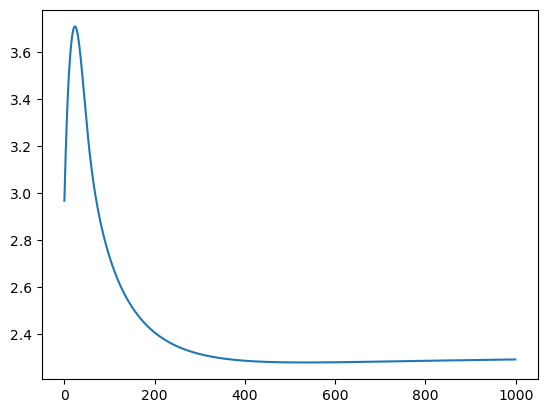

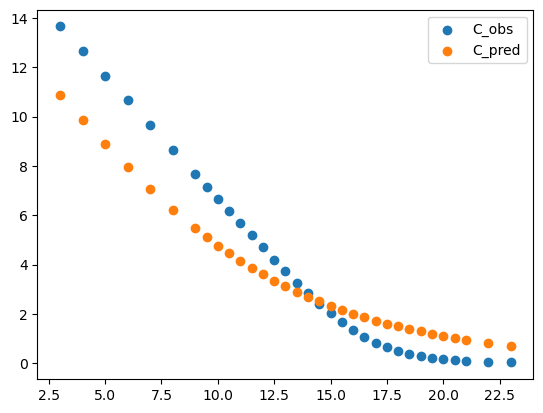

In [65]:

# 查看约束是否满足
left_term, right_term = model.constraint(X)
print("Left term:", left_term)
print("Right term:", right_term)
# 查看pi参数
print("Pi:", model.pi.data, model.pi.data.sum())
print("Sigma:", model.sigma.data)
print("Mu:", model.mu.data)
print("Loss", losses[-1])
# 画出 loss 曲线
plt.plot(losses)
plt.show()
# 画出模型的拟合结果
plt.scatter(X, C_obs, label='C_obs')
plt.scatter(X, model(X_torch).detach().numpy(), label='C_pred')
plt.legend()
plt.show()
